# AdaBoost

## Table of Content 

- [Imports](#imports)
- [Data](#data)
  - [EDA](#eda)
  - [Pipeline For Features](#pipeline-for-features)
  - [Ordinal Encoding For Target](#ordinal-encoding-for-target)
  - [Feature Selection](#feature-selection)
- [Decision Tree Classifier](#decision-tree-classifier)
  - [Decision Tree  Classifier Performance On Training Data](#decision-tree-classifier-performance-on-training-data)
  - [Decision Tree  Classifier Performance On Test Data](#decision-tree-classifier-performance-on-test-data)
- [AdaBoost](#adaboost)
  - [Boosted Model Performance On Training Data](#boosted-model-performance-on-training-data)
  - [Boosted Model Performance On Test Data](#boosted-model-performance-on-test-data)
  - [Grid Search](#grid-search)
  - [Tuned Boosted Model Performance On Training Data](#tuned-boosted-model-performance-on-training-data)
  - [Tuned  Boosted Model Performance On Test Data](#tuned-boosted-model-performance-on-test-data)
- [Performance Table](#performance-table)

In [1]:
# Interactive shell
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "last_expr"

# Data wrangling and standard library
import pandas as pd
from sklearn.base import clone
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
)

# Machine learning
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.tree import DecisionTreeClassifier

# Plotting
%matplotlib inline
# Utilities
import joblib
import matplotlib.pyplot as plt

## Data

This dataset contains the prices and other attributes of 54,000 diamonds. The features are as follow:

* price - the price of the diamond

* carat - the weight of the diamond (0.2--5.01)

* cut - the quality of the cut (Fair, Good, Very Good, Premium, Ideal)

* color - the diamond color, from J (worst) to D (best)

* clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

* x - length in mm (0--10.74)

* y - width in mm (0--58.9)

* z - depth in mm (0--31.8)

* depth - the height of a diamond, measured from the culet to the table, divided by its average girdle diameter (43--79)

* table - the width of the diamond's table expressed as a percentage of its average diameter (43--95)

In [2]:
df = pd.read_parquet("../../../data/regression/diamonds.parquet")
df

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


### EDA

We begin by examining the categorical features of the dataset.

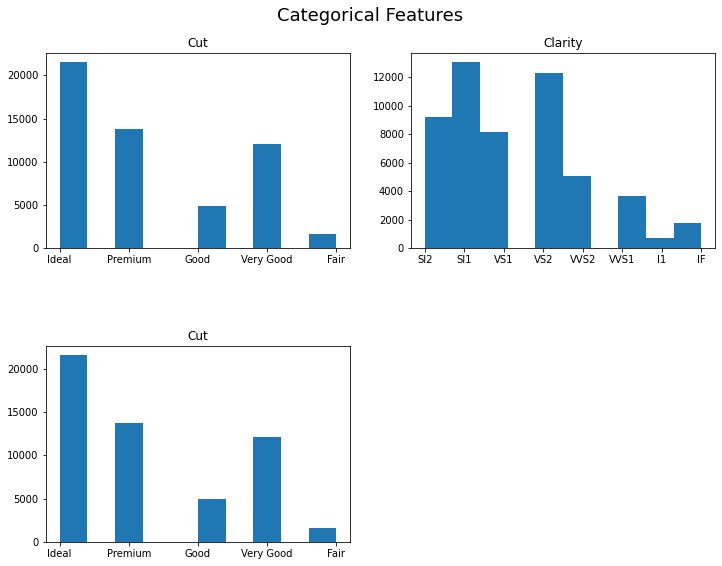

In [3]:
plt.figure(figsize=(12, 9))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Categorical Features", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index
for index, feature in enumerate(["cut", "clarity", "cut"]):
    # Instantiate the subplot
    axes = plt.subplot(2, 2, index + 1)

    # Create histogram
    df[feature].hist(ax=axes)

    # Formatting
    axes.set_title(feature.title())
    axes.grid(False)
    axes.set_xlabel("")

We would like to preserve the proportions of the imbalanced distributions of the target classes in the test set, ensuring that the proportionality of `fair` samples is preserved.

In [4]:
# Cross-validator object of class StratifiedShuffleSplit
cv_object = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=12)
# Use the split() method for the StratifiedShuffleSplit class
# This method generates indices to split data into training and test set
for train_index, test_index in cv_object.split(df.drop(columns="cut"), df["cut"]):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

To check the results of the split:

In [5]:
# Define a function that computes the sample proportions
def prop(data):
    return data.cut.value_counts() / len(data)


# Create a data frame
prop_table = pd.DataFrame(
    {
        "Full Data Set": prop(data=df),
        "Training Set": prop(data=train_set),
        "Test Set": prop(data=test_set),
    }
).sort_index()
# Add error rates using percentage change formula
prop_table["Training set Error Rate %"] = (
    prop_table["Training Set"] / prop_table["Full Data Set"] - 1
) * 100
prop_table["Test set Error Rate %"] = (
    prop_table["Test Set"] / prop_table["Full Data Set"] - 1
) * 100
# Display table
prop_table

,Full Data Set,Training Set,Test Set,Training set Error Rate %,Test set Error Rate %
Fair,0.029848,0.029848,0.029848,0.000000,0.000000
Good,0.090953,0.090948,0.090965,-0.005824,0.013589
Ideal,0.399537,0.399544,0.399518,0.001989,-0.004640
Premium,0.255673,0.255681,0.255654,0.003108,-0.007251
Very Good,0.223990,0.223979,0.224014,-0.004730,0.011036


Finally, we create the training and test splits for the input feature matrix `X` and target vector `y`.

In [6]:
# Train
X_train, y_train = train_set.drop(columns="cut"), train_set.cut
# Test
X_test, y_test = test_set.drop(columns="cut"), test_set.cut

In [7]:
X_train.shape, y_train.shape

((37758, 9), (37758,))

### Pipeline For Features

In [8]:
# First, generate the polynomial features
poly_pipeline = Pipeline(
    steps=[
        ("polynomial", PolynomialFeatures(degree=2, include_bias=False)),
        ("scaler", StandardScaler()),
    ]
)

# Apply one-hot encoding to categorical features
cat_pipeline = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

# Select K-best using ANOVA partial F-test
# A feature will be selected if it statistically significantly reduces error in a simple univariate model between the target and the predictor
select_f_classify = SelectKBest(k=25)

# Build the preprocessor
X_preprocessor = ColumnTransformer(
    transformers=[
        # (7 + 2) choose (2) minus the bias term = 35 vectors returned
        ("poly", poly_pipeline, ["x", "z", "y", "carat", "depth", "table", "price"]),
        ("cat", cat_pipeline, ["color", "clarity"]),
    ]
)

### Ordinal Encoding For Target

In [9]:
# Fit encoder on training set
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)

In [10]:
y_train_encoded

array([3, 2, 1, ..., 3, 3, 4])

In [11]:
y_test_encoded = encoder.fit_transform(y_test)

In [12]:
encoder.classes_

array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object)

### Feature Selection

Using univariate partial F-tests, we obtain the following feature spaces for the training and test sets:

In [13]:
X_train_preprocessed = X_preprocessor.fit_transform(X_train)

The feature scores as as follows:

In [14]:
X_train_preprocessed = select_f_classify.fit_transform(
    X_train_preprocessed, y_train_encoded
)

In [15]:
select_f_classify.scores_

array([3.58213056e+02, 3.69380445e+02, 2.85060211e+02, 3.61429901e+02,
       1.26255181e+03, 4.50796265e+03, 1.22285126e+02, 3.52273268e+02,
       3.51944669e+02, 3.16152113e+02, 3.31006783e+02, 3.99651788e+02,
       8.19483970e+02, 1.33320000e+02, 3.68322713e+02, 3.00719632e+02,
       3.35041993e+02, 4.51105558e+02, 8.30199278e+02, 1.26867897e+02,
       1.06701852e+02, 3.12643489e+02, 3.25131881e+02, 7.04733805e+02,
       1.27419991e+02, 2.82561959e+02, 3.81443582e+02, 4.90663134e+02,
       1.34397027e+02, 1.40101438e+03, 5.68434299e+03, 1.19336179e+02,
       4.42041861e+03, 1.65007341e+02, 7.21460306e+01, 4.76310123e+00,
       7.27381245e+00, 2.65421088e+00, 1.65047677e+01, 1.43550955e+01,
       1.30752573e+00, 1.87953069e+01, 3.16782328e+02, 1.03548341e+02,
       6.48487928e+01, 1.57496283e+02, 1.29537722e+01, 1.90531056e+01,
       9.86778025e+01, 8.66512964e+01])

In [16]:
X_train_preprocessed.shape

(37758, 25)

For the test set:

In [17]:
X_test_preprocessed = X_preprocessor.transform(X_test)

In [18]:
X_test_preprocessed = select_f_classify.fit_transform(
    X_test_preprocessed, y_test_encoded
)

In [19]:
X_test_preprocessed.shape

(16182, 25)

## Decision Tree Classifier

### Grid Search

In [80]:
param_grid = [
    {
        "max_features": ["sqrt", "log2"],
        "max_depth": [1, 25, 50],
        "ccp_alpha": [0.0, 0.25, 0.5, 0.75],
        "min_samples_split": [200, 300, 500],
    }
]

grid_search_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=12),
    param_grid=param_grid,
    # Using StratifiedShuffleSplit to preserve the proportion of each class in the training set
    cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=12).split(
        X_train_preprocessed, y_train_encoded
    ),
    scoring="balanced_accuracy",
    return_train_score=True,
    n_jobs=-1,
    verbose=1,
)

In [81]:
grid_search_tree.fit(X_train_preprocessed, y_train_encoded)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    8.1s finished


GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x134209040>,
             estimator=DecisionTreeClassifier(random_state=12), n_jobs=-1,
             param_grid=[{'ccp_alpha': [0.0, 0.25, 0.5, 0.75],
                          'max_depth': [1, 25, 50],
                          'max_features': ['sqrt', 'log2'],
                          'min_samples_split': [200, 300, 500]}],
             return_train_score=True, scoring='balanced_accuracy', verbose=1)

In [82]:
# Clone the estimator
tree = clone(grid_search_tree.best_estimator_)

In [83]:
# Fit
tree.fit(X_train_preprocessed, y_train_encoded)

DecisionTreeClassifier(max_depth=50, max_features='sqrt', min_samples_split=200,
                       random_state=12)

### Decision Tree Classifier Performance On Training Data

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets

In [84]:
# Predictions
y_pred_tree = tree.predict(X_train_preprocessed)
# Score
balanced_accuracy_score(y_train_encoded, y_pred_tree)

0.6866627108435444

Another performance meature is `f1_score`, which is the harmonic mean of the precision and recall. The metric is calculated for each label and their averages are weighted by the number of true instances for each label, accounting for label imbalance.

In [129]:
# F1 score
f1_tree = f1_score(y_train_encoded, y_pred_tree, average="weighted")
f1_tree

0.7344808435924851

### Decision Tree Classifier Performance On Test Data

In [85]:
y_pred_tree_test = tree.predict(X_test_preprocessed)
# Score
balanced_accuracy_score(y_test_encoded, y_pred_tree_test)

0.3713045811708152

In [130]:
# F1 score
f1_tree_test = f1_score(y_test_encoded, y_pred_tree_test, average="weighted")
f1_tree_test

0.47807150502352963

## AdaBoost

The AdaBoost algorithm using `SVC` as the base estimator:

In [86]:
boosted_model = AdaBoostClassifier(
    base_estimator=grid_search_tree.best_estimator_,
    n_estimators=500,
    # Higher learng rate penalizes weak learners with higher error rates more and rewards stronger learners with lower error rates more
    learning_rate=1,
    random_state=12,
)

In [87]:
boosted_model.fit(X_train_preprocessed, y_train_encoded)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=50,
                                                         max_features='sqrt',
                                                         min_samples_split=200,
                                                         random_state=12),
                   learning_rate=1, n_estimators=500, random_state=12)

In [88]:
joblib.dump(boosted_model, "../models/boosting/adaboost_classifier.pkl")

['../models/boosting/adaboost_classifier.pkl']

### Boosted Model Performance On Training Data

In [89]:
# Predictions
y_pred_ada = boosted_model.predict(X_train_preprocessed)
# Score
balanced_accuracy_score(y_train_encoded, y_pred_ada)

0.8904685019242914

In [131]:
# F1 score
f1_boosted = f1_score(y_train_encoded, y_pred_ada, average="weighted")
f1_boosted

0.8768027905035897

### Boosted Model Performance On Test Data

In [90]:
# Predictions
y_pred_ada_test = boosted_model.predict(X_test_preprocessed)
# Score
balanced_accuracy_score(y_test_encoded, y_pred_ada_test)

0.3481069085765429

In [132]:
# F1 score
f1_boosted_test = f1_score(y_test_encoded, y_pred_ada_test, average="weighted")
f1_boosted_test

0.45442436133401964

### Grid Search

In [91]:
# Fresh base estimator
fresh_tree = clone(grid_search_tree.best_estimator_)

In [102]:
# Parameter space
param_grid = {"n_estimators": [500, 700, 1000], "learning_rate": [0.5, 1, 5, 10]}

# Base estimator
ada_base_estimator = AdaBoostClassifier(base_estimator=fresh_tree, random_state=12)

grid_search_adaboost = GridSearchCV(
    estimator=ada_base_estimator,
    param_grid=param_grid,
    cv=StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=12).split(
        X_train_preprocessed, y_train_encoded
    ),
    # Use a different scoring function to evaluate the model than decision tree
    scoring="f1_weighted",
    return_train_score=True,
    n_jobs=-1,
    verbose=3,
)

In [103]:
grid_search_adaboost.fit(X_train_preprocessed, y_train_encoded)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] learning_rate=0.5, n_estimators=700 .............................
[CV] learning_rate=0.5, n_estimators=500 .............................
[CV] learning_rate=0.5, n_estimators=500 .............................
[CV] learning_rate=0.5, n_estimators=500 .............................
[CV] learning_rate=0.5, n_estimators=500 .............................
[CV] learning_rate=0.5, n_estimators=700 .............................
[CV] learning_rate=0.5, n_estimators=700 .............................
[CV] learning_rate=0.5, n_estimators=500 .............................
[CV]  learning_rate=0.5, n_estimators=500, score=(train=0.886, test=0.726), total= 3.5min
[CV] learning_rate=0.5, n_estimators=700 .............................
[CV]  learning_rate=0.5, n_estimators=500, score=(train=0.884, test=0.732), total= 3.5min
[CV] learning_rate=0.5, n_estimators=700 .............................
[CV]  learning_rate=0.5, n_estimators=500, score=(train=0.884, test=0.723), total= 3.6min
[CV] learning_rate=0

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 11.9min


[CV]  learning_rate=1, n_estimators=500, score=(train=0.879, test=0.725), total= 2.9min
[CV] learning_rate=1, n_estimators=700 ...............................
[CV]  learning_rate=0.5, n_estimators=1000, score=(train=0.890, test=0.730), total= 7.1min
[CV] learning_rate=1, n_estimators=1000 ..............................
[CV]  learning_rate=0.5, n_estimators=1000, score=(train=0.899, test=0.737), total= 7.2min
[CV] learning_rate=1, n_estimators=1000 ..............................
[CV]  learning_rate=1, n_estimators=500, score=(train=0.875, test=0.729), total= 3.1min
[CV] learning_rate=1, n_estimators=1000 ..............................
[CV]  learning_rate=1, n_estimators=700, score=(train=0.883, test=0.731), total= 4.1min
[CV] learning_rate=1, n_estimators=1000 ..............................
[CV]  learning_rate=1, n_estimators=700, score=(train=0.881, test=0.732), total= 3.9min
[CV] learning_rate=1, n_estimators=1000 ..............................
[CV]  learning_rate=1, n_estimators=700,

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.2min finished


GridSearchCV(cv=<generator object BaseShuffleSplit.split at 0x133ecbf20>,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=50,
                                                                                max_features='sqrt',
                                                                                min_samples_split=200,
                                                                                random_state=12),
                                          random_state=12),
             n_jobs=-1,
             param_grid={'learning_rate': [0.5, 1, 5, 10],
                         'n_estimators': [500, 700, 1000]},
             return_train_score=True, scoring='f1_weighted', verbose=3)

In [104]:
grid_search_adaboost.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=50,
                                                         max_features='sqrt',
                                                         min_samples_split=200,
                                                         random_state=12),
                   learning_rate=0.5, n_estimators=1000, random_state=12)

In [105]:
joblib.dump(
    grid_search_adaboost.best_estimator_,
    "../models/boosting/adaboost_best_classifier.pkl",
)

['../models/boosting/adaboost_best_classifier.pkl']

### Tuned Boosted Model Performance On Training Data

In [106]:
# Predictions
y_pred_ada_tuned = grid_search_adaboost.best_estimator_.predict(X_train_preprocessed)
# Score
balanced_accuracy_score(y_train_encoded, y_pred_ada_tuned)

0.8990053357806449

In [133]:
# F1 score
f1_tuned_boosted = f1_score(y_train_encoded, y_pred_ada_tuned, average="weighted")
f1_tuned_boosted

0.8889614329298399

### Tuned Boosted Model Performance On Test Data

In [108]:
# Predictions
y_pred_ada_test_tuned = grid_search_adaboost.best_estimator_.predict(
    X_test_preprocessed
)
# Score
balanced_accuracy_score(y_test_encoded, y_pred_ada_test_tuned)

0.3116713538569985

In [134]:
# F1 score
f1_tuned_boosted_test = f1_score(
    y_test_encoded, y_pred_ada_test_tuned, average="weighted"
)
f1_tuned_boosted_test

0.363779297674835

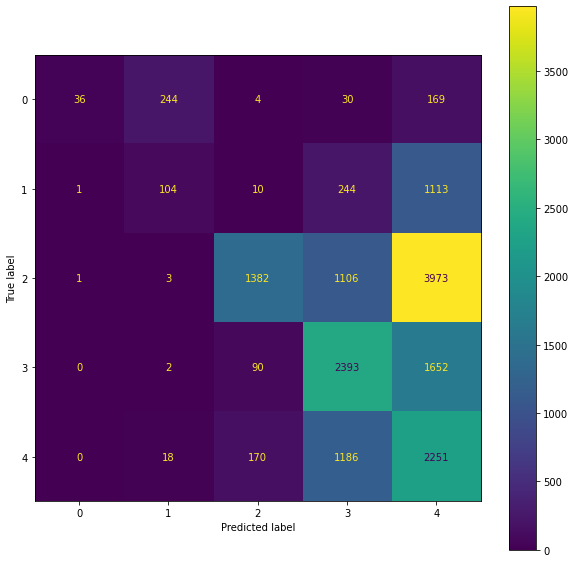

In [128]:
# Create new axes object
fig, ax = plt.subplots(figsize=(10, 10))
# Confusion matrix
cm = ConfusionMatrixDisplay(confusion_matrix(y_test_encoded, y_pred_ada_test_tuned))
cm.plot(ax=ax)

In [126]:
encoder.classes_

array(['Fair', 'Good', 'Ideal', 'Premium', 'Very Good'], dtype=object)

## Performance Table

In [135]:
perf_table = pd.DataFrame(
    {
        "Performance": ["F1 Score (Training Data)", "F1 Score (Test Data)"],
        "DecisionTreeClassifier": [f1_tree, f1_tree_test],
        "AdaBoost With Linear Loss": [f1_boosted, f1_boosted_test],
        "AdaBoost Tuned": [f1_tuned_boosted, f1_tuned_boosted_test],
    }
)
perf_table

,Performance,DecisionTreeClassifier,AdaBoost With Linear Loss,AdaBoost Tuned
0,F1 Score (Training Data),0.734481,0.876803,0.888961
1,F1 Score (Test Data),0.478072,0.454424,0.363779
